# **Статистика для анализа данных**

## **Лабораторная работа №4**  
###**Дисперсионный анализ**


---


**Работу выполнили студенты :**
  - Бабич Александр Петрович, ИСУ: 412882,  Практический поток: 1.3  
  - Московкин Александр Николаевич, ИСУ: 472264,  Практический поток: 1.3  

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind, f_oneway, zscore
from time import time
from itertools import combinations

# Генерация и визуализация данных

In [ ]:
np.random.seed(42)
sigma = 1

In [ ]:
# Генерация данных
def generate_samples(mean_shift):
    group1 = np.random.normal(0, 1, 100)
    group2 = np.random.normal(mean_shift, 1, 100)
    group3 = np.random.normal(-mean_shift, 1, 100)
    return group1, group2, group3

In [ ]:
samples_small_shift = generate_samples(mean_shift=0.2)
samples_large_shift = generate_samples(mean_shift=1.5)

In [ ]:
# Визуализация KDE
def plot_kde(groups, title):
    plt.figure(figsize=(8, 5))
    for i, group in enumerate(groups):
        sns.kdeplot(group, label=f'Группа {i+1}')
    combined = np.concatenate(groups)
    sns.kdeplot(combined, label='Объединение', linestyle='--')
    plt.title(title)
    plt.legend()
    plt.show()

 Графики оценки плотности распределения для каждой группы и их объединения

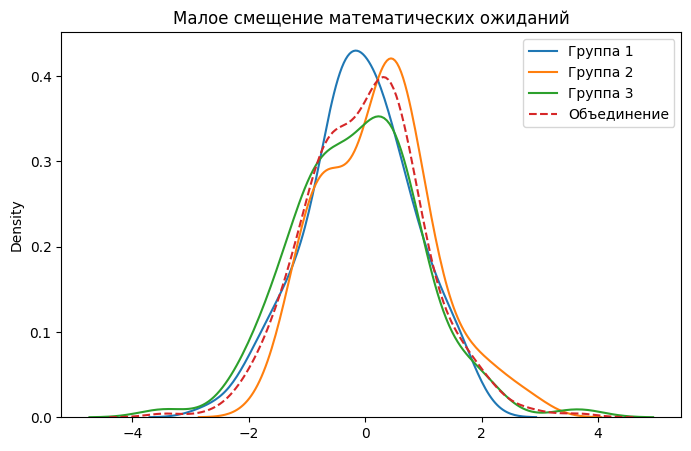

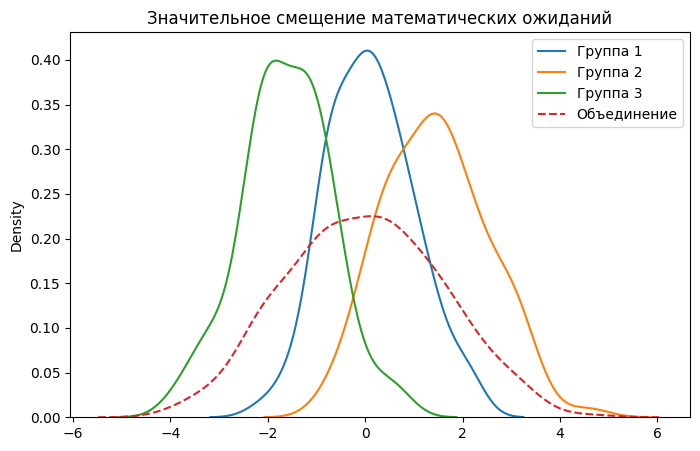

In [ ]:
plot_kde(samples_small_shift, "Малое смещение математических ожиданий")
plot_kde(samples_large_shift, "Значительное смещение математических ожиданий")

📊 Малое смещение математических ожиданий:

На этом графике изображены оценки плотности распределения (KDE) для трёх групп с близкими математическими ожиданиями (около 0, ±0.2). Все три кривые сильно перекрываются и имеют схожую форму. Кривая объединённой выборки почти совпадает с индивидуальными, что указывает на отсутствие существенных различий между группами.

Визуально можно предположить, что группы действительно имеют равные математические ожидания. Это пример ситуации, в которой ANOVA и парные тесты должны не выявить статистически значимых различий.

\\

📊 Значительное смещение математических ожиданий:

Здесь каждая группа имеет ярко выраженное своё «ядро»:

Группа 1 — около 0

Группа 2 — смещена вправо (~ +1.5)

Группа 3 — смещена влево (~ –1.5)

Они почти не перекрываются, а объединённая кривая значительно шире и ниже, отражая высокую дисперсию между группами.

Визуально можно заметить, что график чётко демонстрирует, что группы имеют различные средние значения, и статистические тесты (Z, T, ANOVA) должны выявить эти различия с высокой значимостью.

# Парные тесты

Реализуем Z-критерий для двух выборок с известной дисперсией $\sigma$.

Возвращаем значение статистики Z и $p$-значение для двустороннего теста на равенство средних.

$$ Z = \frac{x - y}{\sigma \cdot \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}, $$

где $x$ и $y$ - выборочные средние, $\sigma$ - известная общая дисперсия, $n_1$ и $n_2$ - размеры выборок.

#### Что такое $p$-value

$p$-value - это вероятность получить значение статистики не менее экстремальное, чем наблюдаемое с обеих сторон:

$$ p = P(|Z| > |z_{набл}|) = 2P(Z > |z_{набл}|) $$



In [ ]:
# Парные тесты
def known_variance_test(x, y, sigma=1):
    n_x = len(x)
    n_y = len(y)
    z = (np.mean(x) - np.mean(y)) / (sigma * np.sqrt(1/n_x + 1/n_y))
    p = 2 * (1 - norm.cdf(np.abs(z)))
    return z, p

Выполняем двухвыборочный T-тест при равных, но неизвестных дисперсиях.

Возвращаем T-статистику и соответствующее $p$-значение.

$$ T = \frac{x - \mu}{\frac{s}{\sqrt{n}}}, $$

где $x$ - выборочное среднее, $\mu$ - предпологаемое среднее, $s$ - стандартное отклонение выборки, $n$ - размер выборки.

In [ ]:
def unknown_variance_test(x, y):
    t_stat, p_val = ttest_ind(x, y, equal_var=True)
    return t_stat, p_val

Применяем оба парных теста ко всем попарным комбинациям групп.

Возвращаем словарь с результатами Z- и T-тестов для каждой пары.

In [ ]:
def apply_pairwise_tests(groups, sigma2):
    results = []
    for (i, g1), (j, g2) in combinations(enumerate(groups), 2):
        z, p_z = known_variance_test(g1, g2, sigma2)
        t, p_t = unknown_variance_test(g1, g2)
        results.append({
            'Пара': f'{i+1}-{j+1}',
            'Z-статистика': z, 'p_z': p_z,
            'T-статистика': t, 'p_t': p_t
        })
    return results

In [ ]:
print("\n== Парные тесты (близкие ожидания) ==")
results_close = apply_pairwise_tests(samples_small_shift, sigma**2)
for r in results_close:
    print(r)


== Парные тесты (близкие ожидания) ==
{'Пара': '1-2', 'Z-статистика': np.float64(-2.3062365764384687), 'p_z': np.float64(0.021097416850737627), 'T-статистика': np.float64(-2.4766375436592214), 'p_t': np.float64(0.014101049720544276)}
{'Пара': '1-3', 'Z-статистика': np.float64(0.22102198944413415), 'p_z': np.float64(0.8250753112511975), 'T-статистика': np.float64(0.22099772176427585), 'p_t': np.float64(0.8253219370683845)}
{'Пара': '2-3', 'Z-статистика': np.float64(2.5272585658826023), 'p_z': np.float64(0.01149568334358464), 'T-статистика': np.float64(2.4751163626450228), 'p_t': np.float64(0.014159399088764773)}


In [ ]:
print("\n== Парные тесты (различные ожидания) ==")
results_far = apply_pairwise_tests(samples_large_shift, sigma**2)
for r in results_far:
    print(r)


== Парные тесты (различные ожидания) ==
{'Пара': '1-2', 'Z-статистика': np.float64(-9.45511657057341), 'p_z': np.float64(0.0), 'T-статистика': np.float64(-9.66732950899965), 'p_t': np.float64(2.3577357322253515e-18)}
{'Пара': '1-3', 'Z-статистика': np.float64(12.17740916068135), 'p_z': np.float64(0.0), 'T-статистика': np.float64(13.470070510902495), 'p_t': np.float64(8.816423994211093e-30)}
{'Пара': '2-3', 'Z-статистика': np.float64(21.632525731254763), 'p_z': np.float64(0.0), 'T-статистика': np.float64(21.717149545121384), 'p_t': np.float64(2.755322655439972e-54)}


# ANOVA

Проводим однофакторный дисперсионный анализ (ANOVA) для сравнения средних между группами.

Возвращаем F-статистику и $p$-значение.

In [ ]:
def anova_test(groups):
    f_stat, p_val = f_oneway(*groups)
    return f_stat, p_val

In [ ]:
anova_small = anova_test(samples_small_shift)
anova_large = anova_test(samples_large_shift)

In [ ]:
f_close, p_close = anova_small
print(f'Близкие ожидания: F = {f_close:.4f}, p = {p_close:.4f}')

Близкие ожидания: F = 4.0395, p = 0.0186


In [ ]:
f_far, p_far = anova_large
print(f'Различные ожидания: F = {f_far:.4f}, p = {p_far:.4f}')

Различные ожидания: F = 255.1101, p = 0.0000


Измеряем и возвращаем время выполнения парных тестов и ANOVA для анализа вычислительной эффективности.

In [ ]:
def time_tests(groups):
    start = time()
    apply_pairwise_tests(groups,1)
    pairwise_time = time() - start

    start = time()
    anova_test(groups)
    anova_time = time() - start

    return pairwise_time, anova_time

In [ ]:
time_small = time_tests(samples_small_shift)
time_large = time_tests(samples_large_shift)

In [ ]:
print("Время (малое смещение): парные тесты =", time_small[0], ", ANOVA =", time_small[1])
print("Время (большое смещение): парные тесты =", time_large[0], ", ANOVA =", time_large[1])

Время (малое смещение): парные тесты = 0.017270803451538086 , ANOVA = 0.0012187957763671875
Время (большое смещение): парные тесты = 0.017058372497558594 , ANOVA = 0.001214742660522461


При малом смещении ANOVA существенно быстрее, особенно при сравнении нескольких групп одновременно. Парные тесты требуют оценки каждой пары по отдельности, что увеличивает количество вычислений. Также при большом смещении, даже при более выраженных различиях во входных данных ANOVA остаётся более эффективным по времени.

Однофакторный дисперсионный анализ (ANOVA) показывает лучшую вычислительную эффективность по сравнению с парными тестами, особенно при увеличении числа групп. Однако парные тесты могут дать более детализированную информацию о различиях между конкретными группами, в отличие от ANOVA, которая оценивает различия в среднем по всем сразу.